In [1]:
import os
import pandas as pd
import numpy as np
import json
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression

# Data Processing

In [2]:
DATA_ROOT = "../data"
PRODUCT_PATH = os.path.join(DATA_ROOT, 'product_detail/json')
BS_PATH = os.path.join(DATA_ROOT, 'bestseller/bsData')

print(f'Product Detail Dir: {os.listdir(PRODUCT_PATH)[0:5]}')
print(f'Best Seller Dir: {os.listdir(BS_PATH)[0:5]}')

Product Detail Dir: ['B071FXZBMV.json', 'B096WLN8XJ.json', 'B09B2QR6LR.json', 'B09T3P7MJ9.json', 'B003I7HS5M.json']
Best Seller Dir: ['industrial_2.json', 'magazines_2.json', 'musical_2.json', 'sports_2.json', 'electronics_1.json']


## Product Detail Data

In [3]:
product_rows = []
product_overview = {}
for filename in os.listdir(PRODUCT_PATH):
    with open(f'{PRODUCT_PATH}/{filename}', 'r') as f:
        product = json.load(f)
        id_, overview = product['id'], product['overview']
        product_overview[id_] = overview
        # remove overview from the product dict
        product.pop('overview')
        # title is the same as id
        product.pop('title')
        # store product in a pandas dataframe
        product_rows.append(product)        


In [4]:
df_prod = pd.DataFrame(product_rows)
print('column data type:\n', df_prod.dtypes)

print('number of rows: ', len(df_prod))
print('number of unique id: ', len(df_prod['id'].unique()))
# Primary Key
assert len(df_prod) == len(df_prod['id'].unique())

df_prod.head()

column data type:
 id               object
price           float64
discount        float64
country          object
quantity          int64
missOverview       bool
missDiscount       bool
missCountry        bool
missQuantity       bool
missPrice          bool
dtype: object
number of rows:  786
number of unique id:  786


,id,price,discount,country,quantity,missOverview,missDiscount,missCountry,missQuantity,missPrice
0,B071FXZBMV,8.99,0.0,US,30,False,True,False,False,False
1,B096WLN8XJ,44.00,0.0,US,2,True,True,False,False,False
2,B09B2QR6LR,17.90,0.0,US,7,True,True,False,False,False
3,B09T3P7MJ9,16.25,0.0,US,13,False,True,False,False,False
4,B003I7HS5M,0.00,0.0,US,0,True,True,False,False,True


In [5]:
product_overview['B071FXZBMV']

{'_Color_': 'Black',
 '_Brand_': 'OHill',
 '_Item_Weight_': '0.15 Pounds',
 '_Binding_': 'Unknown Binding'}

## Best Seller Data

In [6]:
bs_rows = []
bs_overview = {}
for filename in os.listdir(BS_PATH):
    with open(f'{BS_PATH}/{filename}', 'r') as f:
        bs = json.load(f)
        # remove child_categories, next and url from the list
        bs.pop('child_categories')
        bs.pop('next')
        bs.pop('url')
        # now only category and product_listings left
        _category, _product_listings = bs['category'], bs['product_listings']
        for product_listing in _product_listings:
            _id, _rank, _name, _ratings_count, _rating = product_listing['asin'], product_listing['rank'], product_listing['name'], product_listing[
                'ratings_count'], product_listing['rating']
            if _id == None:
                continue
            temp = [_id, _rank, _name, _ratings_count, _rating, _category]
            bs_rows.append(temp)


In [7]:
df_bs = pd.DataFrame(bs_rows)
df_bs.columns = ['id', 'rank', 'name', 'ratings_count', 'rating', 'category']

# convert data type
df_bs['rating'] = df_bs['rating'].astype(float)
df_bs['ratings_count'] = df_bs['ratings_count'].astype(float)
print('column data type:\n', df_bs.dtypes)

# sort data 
df_bs = df_bs.sort_values(by=['category', 'rank'])
df_bs.head()

column data type:
 id                object
rank               int64
name              object
ratings_count    float64
rating           float64
category          object
dtype: object


,id,rank,name,ratings_count,rating,category
397,B079V67BFW,1,"Pampers Choose Your Count, Sensitive Water Bas...",42199.0,4.8,Baby
398,B07SVHLGV8,2,"Diapers Newborn/Size 0 (< 10 lb), 140 Count - ...",54499.0,4.8,Baby
399,B07MB5RY9N,3,"Baby Wipes, Huggies Natural Care Sensitive Bab...",70559.0,4.8,Baby
400,B0779Z53SD,4,"WaterWipes Original Baby Wipes, 99.9% Water, U...",1408.0,4.8,Baby
401,B08QRKY3NJ,5,"Baby Wipes, Unscented, Huggies Simply Clean Fr...",18881.0,4.8,Baby


In [8]:
print('number of rows: ', len(df_bs))
print('number of unique id: ', len(df_bs['id'].unique()))
# print duplicate data
mask = df_bs['id'].duplicated(keep=False)
print('Duplicated Rows:')
df_bs[mask].sort_values('id')
# Drop duplicate
df_bs = df_bs.drop_duplicates(subset=['id'], keep='first')
print('number of rows: ', len(df_bs))
print('number of unique id: ', len(df_bs['id'].unique()))
assert len(df_bs['id']) == len(df_bs['id'].unique())

number of rows:  994
number of unique id:  986
Duplicated Rows:
number of rows:  986
number of unique id:  986


## Join two tables & Define top seller

In [9]:
# join product and bestseller table
df = pd.merge(df_prod, df_bs, on="id")
df.head()

,id,price,discount,country,quantity,missOverview,missDiscount,missCountry,missQuantity,missPrice,rank,name,ratings_count,rating,category
0,B071FXZBMV,8.99,0.0,US,30,False,True,False,False,False,31,"OHill Cable Clips,16 Pack Black Adhesive Cord ...",45032.0,4.5,Electronics
1,B096WLN8XJ,44.00,0.0,US,2,True,True,False,False,False,38,2021 Topps Series 2 Baseball Blaster Box,203.0,4.7,Sports Collectibles
2,B09B2QR6LR,17.90,0.0,US,7,True,True,False,False,False,81,2021 Panini Prizm Draft Picks Football CELLO p...,21.0,4.1,Sports Collectibles
3,B09T3P7MJ9,16.25,0.0,US,13,False,True,False,False,False,7,"Kitchens Slow Cooker Liners, Regular (Fits 3-8...",NaN,NaN,Kitchen & Dining
4,B003I7HS5M,0.00,0.0,US,0,True,True,False,False,True,40,Ranger Rick Jr.,1595.0,4.7,Magazine Subscriptions


In [10]:
# remove NAN
df = df.dropna()
df.head()

,id,price,discount,country,quantity,missOverview,missDiscount,missCountry,missQuantity,missPrice,rank,name,ratings_count,rating,category
0,B071FXZBMV,8.99,0.00,US,30,False,True,False,False,False,31,"OHill Cable Clips,16 Pack Black Adhesive Cord ...",45032.0,4.5,Electronics
1,B096WLN8XJ,44.00,0.00,US,2,True,True,False,False,False,38,2021 Topps Series 2 Baseball Blaster Box,203.0,4.7,Sports Collectibles
2,B09B2QR6LR,17.90,0.00,US,7,True,True,False,False,False,81,2021 Panini Prizm Draft Picks Football CELLO p...,21.0,4.1,Sports Collectibles
4,B003I7HS5M,0.00,0.00,US,0,True,True,False,False,True,40,Ranger Rick Jr.,1595.0,4.7,Magazine Subscriptions
5,B005HNZ5T6,11.60,13.36,US,90,False,False,False,False,False,69,"uni-ball 207 Retractable Gel Pens, Bold Point ...",28045.0,4.7,Office Products


In [11]:
# define top seller: rank < 50
df['label'] = 0
top_idx = df['rank'] < 50
df[top_idx] = df[top_idx].assign(label=1)
df.head()

,id,price,discount,country,quantity,missOverview,missDiscount,missCountry,missQuantity,missPrice,rank,name,ratings_count,rating,category,label
0,B071FXZBMV,8.99,0.00,US,30,False,True,False,False,False,31,"OHill Cable Clips,16 Pack Black Adhesive Cord ...",45032.0,4.5,Electronics,1
1,B096WLN8XJ,44.00,0.00,US,2,True,True,False,False,False,38,2021 Topps Series 2 Baseball Blaster Box,203.0,4.7,Sports Collectibles,1
2,B09B2QR6LR,17.90,0.00,US,7,True,True,False,False,False,81,2021 Panini Prizm Draft Picks Football CELLO p...,21.0,4.1,Sports Collectibles,0
4,B003I7HS5M,0.00,0.00,US,0,True,True,False,False,True,40,Ranger Rick Jr.,1595.0,4.7,Magazine Subscriptions,1
5,B005HNZ5T6,11.60,13.36,US,90,False,False,False,False,False,69,"uni-ball 207 Retractable Gel Pens, Bold Point ...",28045.0,4.7,Office Products,0


# ML Model
## Model
* Logistics Regression

## Experiments
1. basic one, use cross validation to find the best hyper parameter
2. explore how different scale method influence the experiment results
3. explore how different data feature influence the experiment results

In [12]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

In [13]:
df = df.sample(frac=1, random_state=42)
df[['price', 'discount' , 'rating', 'ratings_count', 'category', 'label']].head()

,price,discount,rating,ratings_count,category,label
362,119.00,30.99,4.3,792.0,Camera & Photo Products,0
515,16.99,0.00,4.4,18012.0,Electronics,1
587,0.00,0.00,4.5,25591.0,Industrial & Scientific,0
255,0.00,0.00,4.8,1175.0,Industrial & Scientific,1
350,9.98,4.01,4.3,6561.0,Industrial & Scientific,0


In [14]:
# one hot encoding
df_cat = df['category'].to_numpy().reshape(-1,1)
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(df_cat)
cat_ = enc.transform(df_cat)
cat_.shape

(774, 8)

In [15]:
X = df[['price', 'discount' , 'rating', 'ratings_count']].to_numpy()

# concate one hot category to X
print('before concate one hot category: ', X.shape)
X_c = np.concatenate([X, cat_], axis=1)
print('after concate one hot category: ', X_c.shape)

y = df['label'].to_numpy()

before concate one hot category:  (774, 4)
after concate one hot category:  (774, 12)


## Experiment 1
- basic one, use cross validation to find the best hyper parameter
- WARN: Since the dataset size is small，test acc is highly dependent on train/test dataset spliting. Therefore we test or validate for multiple times and then take the average accuracy.

In [16]:
# Use K-fold cross validation to select best parameters
def KFoldTest(data, label, param, n_splits=5, n_repeats=100):
    kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
    val_acc_list = []
    for train_idx, val_idx in kf.split(data):
        # train and val data
        data_train, label_train = data[train_idx], label[train_idx]
        data_val, label_val = data[val_idx], label[val_idx]
        # build a model
        model = LogisticRegression(**param)
        model.fit(data_train, label_train)
        val_acc = model.score(data_val, label_val)
        val_acc_list.append(val_acc)
    avg_val_acc = np.mean(val_acc_list)
    return val_acc_list, avg_val_acc

val_acc_list, avg_val_acc = KFoldTest(data=X_c, label=y, param={})
print(f'Average val acc:{avg_val_acc}')

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Average val acc:0.5544138248847926


In [17]:
import warnings
warnings.filterwarnings('ignore')

def best_param_search(data, label, Cs, penalties):
    solver = 'liblinear'
    print(f"## Searching for best parameters using solver: {solver}")

    best_penalty = 'l1'
    best_c = 0.1
    max_val_acc = 0

    pen2acc = {'l1':[], 'l2':[], 'none':[]}
    for penalty in penalties:
        print(f'== penalty:{penalty} ==')
        for c in Cs:
            _, avg_val_acc = KFoldTest(data=data, label=label, param={'C':c, 'penalty':penalty, 'solver':solver})
            pen2acc[penalty].append(avg_val_acc)
            if avg_val_acc > max_val_acc:
                best_penalty, best_c = penalty, c
                max_val_acc = avg_val_acc
            print(f'c:{c:.4f}, val_acc:{avg_val_acc:.4f}')
    print(f'best_penalty:{best_penalty}, best_c:{best_c}, max_val_acc:{max_val_acc:.4f}')
    return best_penalty, best_c, pen2acc

In [18]:
Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
penalties = ['l1', 'l2']
best_penalty, best_c, pen2acc = best_param_search(X_c, y, Cs, penalties)

## Searching for best parameters using solver: liblinear
== penalty:l1 ==
c:0.1000, val_acc:0.5743
c:0.2000, val_acc:0.5738
c:0.3000, val_acc:0.5716
c:0.4000, val_acc:0.5667
c:0.5000, val_acc:0.5667
c:0.6000, val_acc:0.5654
c:0.7000, val_acc:0.5619
c:0.8000, val_acc:0.5621
c:0.9000, val_acc:0.5629
c:1.0000, val_acc:0.5620
== penalty:l2 ==
c:0.1000, val_acc:0.5570
c:0.2000, val_acc:0.5567
c:0.3000, val_acc:0.5540
c:0.4000, val_acc:0.5541
c:0.5000, val_acc:0.5541
c:0.6000, val_acc:0.5547
c:0.7000, val_acc:0.5536
c:0.8000, val_acc:0.5550
c:0.9000, val_acc:0.5574
c:1.0000, val_acc:0.5559
best_penalty:l1, best_c:0.1, max_val_acc:0.5743


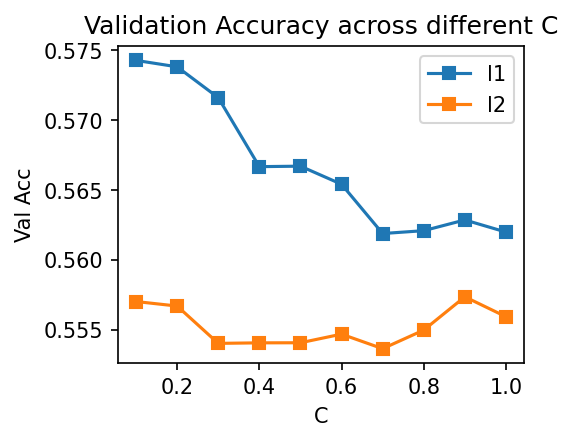

In [19]:
# Draw 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams["figure.figsize"] = (3.5,2.8)

plt.plot(Cs, pen2acc['l1'],'s-', label='l1')
plt.plot(Cs, pen2acc['l2'],'s-', label='l2')
plt.xlabel('C')
plt.ylabel('Val Acc')
plt.legend(loc='best')
plt.title('Validation Accuracy across different C')
plt.show()

In [21]:
# Choose the best hyper paramter and test 
def train_test_N_times(param, data, label, N=200, test_size=0.3):
    """
        Create a model according to the parameter
        Train it on data and label for N times
        Return the average train acc and test acc
    """
    train_acc_list = []
    test_acc_list = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=test_size)
        model = LogisticRegression(**param)
        model.fit(X_train, y_train)
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
    return np.mean(train_acc_list), np.mean(test_acc_list)

solver = 'liblinear'
param = {'C':best_c, 'penalty':best_penalty, 'solver':solver}
best_train_acc, best_test_acc = train_test_N_times(param, X_c, y)
print(f"train_acc:{best_train_acc:.3f} test_acc:{best_test_acc:.3f} For Best Parameters")
de_train_acc, de_test_acc = train_test_N_times({}, X_c, y)
print(f"train_acc:{de_train_acc:.3f} test_acc:{de_test_acc:.3f} For Default Parameters")

train_acc:0.584 test_acc:0.571 For Best Parameters
train_acc:0.565 test_acc:0.548 For Default Parameters


In [42]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X_c, y)
param = {'C':best_c, 'penalty':best_penalty, 'solver':solver}
model = LogisticRegression(**param)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# true negatives is C_00, false negatives is C_10,  
# true positives is C_11, and false positives is C_01
print(confusion_matrix(y_test, y_pred))


[[78 25]
 [53 38]]


In [57]:
from collections import defaultdict
# Error across different categories
pred = y_pred == y_test
error_cat = defaultdict(int)
for i in range(pred.shape[0]):
    if pred[i] == False:
        cat_vec = X_test[i][4:].reshape(1, -1)
        cat_ = enc.inverse_transform(cat_vec)[0][0]
        error_cat[cat_] += 1

print(error_cat)

defaultdict(<class 'int'>, {'Electronics': 11, 'Industrial & Scientific': 9, 'Kitchen & Dining': 16, 'Sports Collectibles': 10, 'Office Products': 7, 'Baby': 5, 'Camera & Photo Products': 12, 'Magazine Subscriptions': 8})


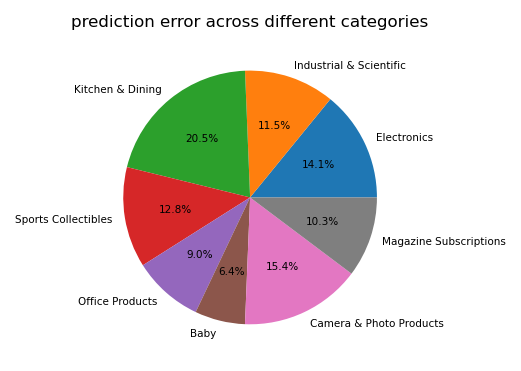

In [72]:
import matplotlib.pyplot as plt
import numpy as np

ks,vs = [], []

for k, v in error_cat.items():
    ks.append(k)
    vs.append(v)
    
plt.pie(vs, labels=ks, textprops={'fontsize': 5}, autopct='%1.1f%%')
plt.title('prediction error across different categories', size=8)
plt.show()

## Experiment 2
- explore how different scale method influence the experiment results

### Standard Normalize

In [147]:
scaler = preprocessing.StandardScaler().fit(X_c[:, 0:4])
X_c_stdnorm = np.zeros_like(X_c)
X_c_stdnorm[:, 0:4] = scaler.transform(X_c[:, 0:4])
X_c_stdnorm[:, 4:] = X_c[:, 4:]
print(X_c[0:3])
print(X_c_stdnorm[0:3])

[[1.1832e+02 0.0000e+00 4.5000e+00 6.2000e+01 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00]
 [1.2990e+01 0.0000e+00 4.6000e+00 2.8005e+04 1.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.5990e+01 0.0000e+00 4.5000e+00 8.5630e+03 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]
[[-0.03077799 -0.25231218 -0.19641436 -0.44588104  0.          0.
   0.          0.          0.          0.          0.          1.        ]
 [-0.03741913 -0.25231218  0.17257767  0.09312532  1.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.03722998 -0.25231218 -0.19641436 -0.28190104  0.          0.
   0.          0.          1.          0.          0.          0.        ]]


In [150]:

# Use K-fold to select the best hyper parameters
Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
penalties = ['l1', 'l2']
best_penalty, best_c, pen2acc = best_param_search(X_c_stdnorm, y, Cs, penalties)

print('Use Standard Scaler')
param = {'C':best_c, 'penalty':best_penalty, 'solver':solver}
best_train_acc, best_test_acc = train_test_N_times(param, X_c_stdnorm, y)
print(f"train_acc:{best_train_acc:.3f} test_acc:{best_test_acc:.3f} For Best Parameters")
de_train_acc, de_test_acc = train_test_N_times({}, X_c_stdnorm, y)
print(f"train_acc:{de_train_acc:.3f} test_acc:{de_test_acc:.3f} For Default Parameters")


## Searching for best parameters using solver: liblinear
== penalty:l1 ==
c:0.1000, val_acc:0.5679
c:0.2000, val_acc:0.5651
c:0.3000, val_acc:0.5593
c:0.4000, val_acc:0.5570
c:0.5000, val_acc:0.5571
c:0.6000, val_acc:0.5562
c:0.7000, val_acc:0.5568
c:0.8000, val_acc:0.5590
c:0.9000, val_acc:0.5578
c:1.0000, val_acc:0.5571
== penalty:l2 ==
c:0.1000, val_acc:0.5568
c:0.2000, val_acc:0.5588
c:0.3000, val_acc:0.5617
c:0.4000, val_acc:0.5592
c:0.5000, val_acc:0.5599
c:0.6000, val_acc:0.5603
c:0.7000, val_acc:0.5584
c:0.8000, val_acc:0.5591
c:0.9000, val_acc:0.5610
c:1.0000, val_acc:0.5602
best_penalty:l1, best_c:0.1, max_val_acc:0.5679
Use Standard Scaler
train_acc:0.578 test_acc:0.567 For Best Parameters
train_acc:0.603 test_acc:0.556 For Default Parameters


### MinMax Normalize

In [162]:
scaler = preprocessing.MinMaxScaler().fit(X_c[:, 0:4])
X_c_minmaxnorm = np.zeros_like(X_c)
X_c_minmaxnorm[:, 0:4] = scaler.transform(X_c[:, 0:4])
X_c_minmaxnorm[:, 4:] = X_c[:, 4:]
print(X_c[0:3])
print(X_c_minmaxnorm[0:3])

# print(np.max(X[:, 0]), np.min(X[:, 0]))

[[1.1832e+02 0.0000e+00 4.5000e+00 6.2000e+01 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00]
 [1.2990e+01 0.0000e+00 4.6000e+00 2.8005e+04 1.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.5990e+01 0.0000e+00 4.5000e+00 8.5630e+03 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]
[[2.67973152e-04 0.00000000e+00 8.07692308e-01 6.97097446e-05
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [2.94199733e-05 0.00000000e+00 8.46153846e-01 3.20024867e-02
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.62144245e-05 0.00000000e+00 8.07692308e-01 9.78450547e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [163]:

# Use K-fold to select the best hyper parameters

best_penalty, best_c, pen2acc = best_param_search(X_c_minmaxnorm, y, Cs, penalties)

print('Use MinMax Scaler')
param = {'C':best_c, 'penalty':best_penalty, 'solver':solver}
best_train_acc, best_test_acc = train_test_N_times(param, X_c_minmaxnorm, y)
print(f"train_acc:{best_train_acc:.3f} test_acc:{best_test_acc:.3f} For Best Parameters")
de_train_acc, de_test_acc = train_test_N_times({}, X_c_minmaxnorm, y)
print(f"train_acc:{de_train_acc:.3f} test_acc:{de_test_acc:.3f} For Default Parameters")


## Searching for best parameters using solver: liblinear
== penalty:l1 ==
c:0.1000, val_acc:0.5103
c:0.2000, val_acc:0.5034
c:0.3000, val_acc:0.4903
c:0.4000, val_acc:0.4811
c:0.5000, val_acc:0.4973
c:0.6000, val_acc:0.5187
c:0.7000, val_acc:0.5206
c:0.8000, val_acc:0.5252
c:0.9000, val_acc:0.5272
c:1.0000, val_acc:0.5284
== penalty:l2 ==
c:0.1000, val_acc:0.4475
c:0.2000, val_acc:0.4566
c:0.3000, val_acc:0.4587
c:0.4000, val_acc:0.4616
c:0.5000, val_acc:0.4658
c:0.6000, val_acc:0.4729
c:0.7000, val_acc:0.4725
c:0.8000, val_acc:0.4739
c:0.9000, val_acc:0.4795
c:1.0000, val_acc:0.4828
best_penalty:l1, best_c:1.0, max_val_acc:0.5284
Use MinMax Scaler
train_acc:0.579 test_acc:0.510 For Best Parameters
train_acc:0.562 test_acc:0.486 For Default Parameters


## Experiment 3
- explore how different data features influence the experiment results

before concate one hot category:  (774, 4)
after concate one hot category:  (774, 12)


1. Without category data

In [180]:
X = df[['price', 'discount' , 'rating', 'ratings_count']].to_numpy()
y = df['label'].to_numpy()

Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
penalties = ['l1', 'l2']
best_penalty, best_c, pen2acc = best_param_search(X, y, Cs, penalties)

print('Without Catgory Information')
param = {'C':best_c, 'penalty':best_penalty, 'solver':solver}
best_train_acc, best_test_acc = train_test_N_times(param, X, y)
print(f"train_acc:{best_train_acc:.3f} test_acc:{best_test_acc:.3f} For Best Parameters")
de_train_acc, de_test_acc = train_test_N_times({}, X, y)
print(f"train_acc:{de_train_acc:.3f} test_acc:{de_test_acc:.3f} For Default Parameters")

no_cat_acc = best_test_acc

## Searching for best parameters using solver: liblinear
== penalty:l1 ==
c:0.1000, val_acc:0.5735
c:0.2000, val_acc:0.5739
c:0.3000, val_acc:0.5756
c:0.4000, val_acc:0.5735
c:0.5000, val_acc:0.5746
c:0.6000, val_acc:0.5746
c:0.7000, val_acc:0.5742
c:0.8000, val_acc:0.5736
c:0.9000, val_acc:0.5744
c:1.0000, val_acc:0.5737
== penalty:l2 ==
c:0.1000, val_acc:0.5534
c:0.2000, val_acc:0.5585
c:0.3000, val_acc:0.5526
c:0.4000, val_acc:0.5530
c:0.5000, val_acc:0.5535
c:0.6000, val_acc:0.5549
c:0.7000, val_acc:0.5537
c:0.8000, val_acc:0.5568
c:0.9000, val_acc:0.5560
c:1.0000, val_acc:0.5566
best_penalty:l1, best_c:0.3, max_val_acc:0.5756
Without Catgory Information
train_acc:0.583 test_acc:0.575 For Best Parameters
train_acc:0.564 test_acc:0.553 For Default Parameters


2. without price

In [181]:
X = df[['discount' , 'rating', 'ratings_count']].to_numpy()

# concate one hot category to X
# print('before concate one hot category: ', X.shape)
X_ = np.concatenate([X, cat_], axis=1)
# print('after concate one hot category: ', X_c.shape)

y = df['label'].to_numpy()

Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
penalties = ['l1', 'l2']
best_penalty, best_c, pen2acc = best_param_search(X_, y, Cs, penalties)

print('Without Price Information')
param = {'C':best_c, 'penalty':best_penalty, 'solver':solver}
best_train_acc, best_test_acc = train_test_N_times(param, X_, y)
print(f"train_acc:{best_train_acc:.3f} test_acc:{best_test_acc:.3f} For Best Parameters")
de_train_acc, de_test_acc = train_test_N_times({}, X_, y)
print(f"train_acc:{de_train_acc:.3f} test_acc:{de_test_acc:.3f} For Default Parameters")

no_price_acc = best_test_acc

## Searching for best parameters using solver: liblinear
== penalty:l1 ==
c:0.1000, val_acc:0.5735
c:0.2000, val_acc:0.5736
c:0.3000, val_acc:0.5718
c:0.4000, val_acc:0.5704
c:0.5000, val_acc:0.5658
c:0.6000, val_acc:0.5649
c:0.7000, val_acc:0.5631
c:0.8000, val_acc:0.5639
c:0.9000, val_acc:0.5603
c:1.0000, val_acc:0.5633
== penalty:l2 ==
c:0.1000, val_acc:0.5429
c:0.2000, val_acc:0.5466
c:0.3000, val_acc:0.5458
c:0.4000, val_acc:0.5448
c:0.5000, val_acc:0.5409
c:0.6000, val_acc:0.5453
c:0.7000, val_acc:0.5451
c:0.8000, val_acc:0.5450
c:0.9000, val_acc:0.5458
c:1.0000, val_acc:0.5461
best_penalty:l1, best_c:0.2, max_val_acc:0.5736
Without Price Information
train_acc:0.584 test_acc:0.574 For Best Parameters
train_acc:0.513 test_acc:0.503 For Default Parameters


**Without discount**

In [182]:
print('Without discount Information')

X = df[['price' , 'rating', 'ratings_count']].to_numpy()

# concate one hot category to X
# print('before concate one hot category: ', X.shape)
X_ = np.concatenate([X, cat_], axis=1)
# print('after concate one hot category: ', X_c.shape)

y = df['label'].to_numpy()

Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
penalties = ['l1']
best_penalty, best_c, pen2acc = best_param_search(X_, y, Cs, penalties)

param = {'C':best_c, 'penalty':best_penalty, 'solver':solver}
best_train_acc, best_test_acc = train_test_N_times(param, X_, y)
print(f"train_acc:{best_train_acc:.3f} test_acc:{best_test_acc:.3f} For Best Parameters")
de_train_acc, de_test_acc = train_test_N_times({}, X_, y)
print(f"train_acc:{de_train_acc:.3f} test_acc:{de_test_acc:.3f} For Default Parameters")

no_discount_acc = best_test_acc

Without discount Information
## Searching for best parameters using solver: liblinear
== penalty:l1 ==
c:0.1000, val_acc:0.5758
c:0.2000, val_acc:0.5766
c:0.3000, val_acc:0.5728
c:0.4000, val_acc:0.5681
c:0.5000, val_acc:0.5680
c:0.6000, val_acc:0.5676
c:0.7000, val_acc:0.5662
c:0.8000, val_acc:0.5652
c:0.9000, val_acc:0.5651
c:1.0000, val_acc:0.5639
best_penalty:l1, best_c:0.2, max_val_acc:0.5766
train_acc:0.585 test_acc:0.577 For Best Parameters
train_acc:0.563 test_acc:0.546 For Default Parameters


In [183]:
print('Without rating Information')

X = df[['price' , 'discount', 'ratings_count']].to_numpy()

# concate one hot category to X
# print('before concate one hot category: ', X.shape)
X_ = np.concatenate([X, cat_], axis=1)
# print('after concate one hot category: ', X_c.shape)

y = df['label'].to_numpy()

Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
penalties = ['l1']
best_penalty, best_c, pen2acc = best_param_search(X_, y, Cs, penalties)

param = {'C':best_c, 'penalty':best_penalty, 'solver':solver}
best_train_acc, best_test_acc = train_test_N_times(param, X_, y)
print(f"train_acc:{best_train_acc:.3f} test_acc:{best_test_acc:.3f} For Best Parameters")
de_train_acc, de_test_acc = train_test_N_times({}, X_, y)
print(f"train_acc:{de_train_acc:.3f} test_acc:{de_test_acc:.3f} For Default Parameters")

no_rate_acc = best_test_acc

Without rating Information
## Searching for best parameters using solver: liblinear
== penalty:l1 ==
c:0.1000, val_acc:0.5645
c:0.2000, val_acc:0.5691
c:0.3000, val_acc:0.5695
c:0.4000, val_acc:0.5647
c:0.5000, val_acc:0.5653
c:0.6000, val_acc:0.5639
c:0.7000, val_acc:0.5637
c:0.8000, val_acc:0.5644
c:0.9000, val_acc:0.5654
c:1.0000, val_acc:0.5625
best_penalty:l1, best_c:0.3, max_val_acc:0.5695
train_acc:0.590 test_acc:0.569 For Best Parameters
train_acc:0.525 test_acc:0.514 For Default Parameters


In [184]:
print('Without ratings_count Information')

X = df[['price' , 'discount', 'rating']].to_numpy()

# concate one hot category to X
# print('before concate one hot category: ', X.shape)
X_ = np.concatenate([X, cat_], axis=1)
# print('after concate one hot category: ', X_c.shape)

y = df['label'].to_numpy()

Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
penalties = ['l1']
best_penalty, best_c, pen2acc = best_param_search(X_, y, Cs, penalties)

param = {'C':best_c, 'penalty':best_penalty, 'solver':solver}
best_train_acc, best_test_acc = train_test_N_times(param, X_, y)
print(f"train_acc:{best_train_acc:.3f} test_acc:{best_test_acc:.3f} For Best Parameters")
de_train_acc, de_test_acc = train_test_N_times({}, X_, y)
print(f"train_acc:{de_train_acc:.3f} test_acc:{de_test_acc:.3f} For Default Parameters")

no_rate_cnt_acc = best_test_acc

Without ratings_count Information
## Searching for best parameters using solver: liblinear
== penalty:l1 ==
c:0.1000, val_acc:0.4806
c:0.2000, val_acc:0.4801
c:0.3000, val_acc:0.4703
c:0.4000, val_acc:0.4627
c:0.5000, val_acc:0.4559
c:0.6000, val_acc:0.4522
c:0.7000, val_acc:0.4492
c:0.8000, val_acc:0.4479
c:0.9000, val_acc:0.4464
c:1.0000, val_acc:0.4428
best_penalty:l1, best_c:0.1, max_val_acc:0.4806
train_acc:0.513 test_acc:0.476 For Best Parameters
train_acc:0.533 test_acc:0.471 For Default Parameters


[0.0054163090128754865, 0.0016609442060084856, 0.009772532188841221, 0.10307725321888411, 0.0035708154506437495]


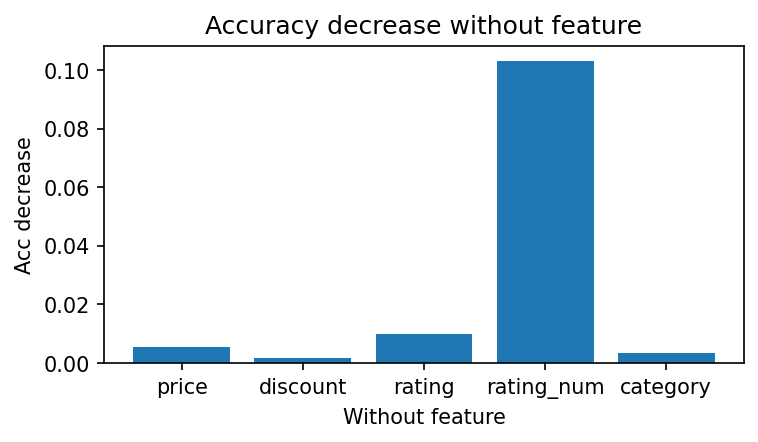

In [200]:
best_test_acc = 0.579
no_feat = ['price', 'discount', 'rating', 'rating_num', 'category']
no_feat_acc = [no_price_acc, no_discount_acc, no_rate_acc, no_rate_cnt_acc, no_cat_acc]
acc_diff = [best_test_acc - acc for acc in no_feat_acc]

print(acc_diff)
plt.rcParams["figure.figsize"] = (5.5,2.8)
plt.title('Accuracy decrease without feature')
plt.ylabel('Acc decrease')
plt.xlabel('Without feature')

plt.bar(no_feat, acc_diff)
plt.show()

# How features influence the final result

# Questions

* ### Did you have to clean or restructure your data?
    * Yes. Some of our data contains N/A property. Therefore we should drop these rows.
    * We also use onehot encoding to transfer categorical variable into numerical. 
    
* ### Why did you use this statistical test or ML algorithm? 
    * Our goal is to predict whether a product will be a top-seller. We define top sellers as top 50 products in the list. Therefore it is a binary classification problem. 
    * Since we have a label for each product (is top-seller or not), we should use supervised learning paradigm.
    * Our dataset size is relatively small (less than 800 data points), therefore we should avoid using complicated models such as Deep Learning which may easily overfit the dataset.
    * In short, we should choose a *simple*, *supervised* machine learning model for a *binary classification* problem. Therefore Logistics Regression is a great choice.
    
* ### Which other tests did you consider or evaluate? 
    * Besides normal accuracy test, we also conduct experiments to explore: (1) how different scale method influence the experiment results, (2) explore how different features influence the experiment results
    
* ### How did you measure success or failure?
    * We measure success by evaluating if the model can predict a product in the testset is top-seller or not correctly.
    * Specifically, we use accuracy in our experiment.
    
* ### Why that metric/value? 
    * In our definition, top-seller products defined as top 50 products is labeled positive, and the rest 50 products is labeled negative. 
    * Since the label classes is balanced, accuracy is a great choice.
    
* ### What challenges did you face evaluating the model? 
    * Since we are trying to explore the how the model performance is influenced by different hyper-parameters and features, we find it hard to structure the code to run these experiments in a orgnized way. For example, sklearn provide API for hyperparameter grid search, while hyperparameters are not necessarily compatible with each other, e.g., lbfgs solver can only be used under 'l2' regularization. 
    * Also since our dataset is relatively small, the test accuracy may vary from time to time. Therefore we choose to repeat test for 100 times and then compute the average accuracy.
    
* ### What is your interpretation of the results? 
    * Our best test accuracy is 57%, which means we can predict the label correctly about 57 times out of 100 trials.
* ### Do you accept or deny the hypothesis, or are you satisfied with your prediction accuracy?
    * We are not quite satisfied with the prediction accuracy. 
* ### For prediction projects, we expect you to argue why you got the accuracy/success metric you have. 
    * ???
* ### Intuitively, how do you react to the results? Are you confident in the results?
    * ???